### Cell 1: Import libraries

In [1]:
# data handling
import pandas as pd         # for CSV I/O and DataFrame ops
import numpy as np          # for numerical operations

# train/test split and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, precision_recall_curve,
    ConfusionMatrixDisplay, confusion_matrix
)

# TensorFlow / Keras for building & training the DNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers, regularizers

# KerasTuner for automated hyperparameter search
import keras_tuner as kt

# plotting
import matplotlib.pyplot as plt

import os
import joblib
import json


### Cell 2: Load and split data

In [2]:
# Read CSV into DataFrame
df = pd.read_csv("../data/selected_expression_data.csv")

# Separate features (X) and label (y)
X = df.drop("label", axis=1).values  # all columns except 'label'
y = df["label"].values               # binary target

# Stratified split to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% held out for final evaluation
    random_state=42,      # reproducible split
    stratify=y            # keep class proportions
)

# Confirm shapes
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (228, 70), Test: (58, 70)


### Cell 3: Preprocess - scaling

In [3]:
# Instantiate scaler
scaler = StandardScaler()

# Fit on train data and transform
X_train = scaler.fit_transform(X_train)

# Only transform test data
X_test = scaler.transform(X_test)

### Cell 4: Model-builder for tuning

In [4]:
# Define a build_model() function for KerasTuner

def build_model(hp):
    """
    Build a Sequential DNN where:
      - number of hidden layers is tuned (1–4)
      - units per layer is tuned (32–256)
      - activation, batchnorm, dropout, and dropout rate are tuned
      - learning rate is tuned (1e-4 to 1e-2)
    """
    model = keras.Sequential()
    
    # Loop to add hidden layers
    for i in range(hp.Int("num_layers", 1, 4)):
        # Dense layer with tunable units & activation
        model.add(layers.Dense(
            units=hp.Int(f"units_{i}", 32, 256, step=32),
            activation=hp.Choice("activation", ["relu", "tanh"])
        ))
        # Optional batch normalization
        if hp.Boolean(f"batchnorm_{i}"):
            model.add(layers.BatchNormalization())
        # Optional dropout with tunable rate
        if hp.Boolean(f"dropout_{i}"):
            model.add(layers.Dropout(
                hp.Float(f"drop_rate_{i}", 0.1, 0.5, step=0.1)
            ))
    
    # Output layer for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))
    
    # Compile with Adam optimizer and tunable learning rate
    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=hp.Float("lr", 1e-4, 1e-2, sampling="log")
        ),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            keras.metrics.AUC(name="auc")
        ]
    )
    return model

### Cell 5: Set up the tuner

In [5]:
# Configure KerasTuner RandomSearch
tuner = kt.RandomSearch(
    build_model,               # function that builds models
    objective="val_auc",       # maximize ROC-AUC on validation set
    max_trials=50,            # number of hyperparameter combinations to try
    executions_per_trial=2,    # average performance over 2 runs each
    directory="ktuner_logs",   # where to save logs
    project_name="dnn_finetune"  
)

# Display the search space for verification
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
batchnorm_0 (Boolean)
{'default': False, 'conditions': []}
dropout_0 (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


### Cell 6: Run search

In [6]:
# Perform hyperparameter search with early stopping
# Early stopping to prevent overfitting
es = callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    restore_best_weights=True
)

# Compute class weights to address imbalance
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
class_weight = {0: 1, 1: neg / pos}

# Launch search
tuner.search(
    X_train, y_train,
    epochs=200,              # maximum epochs per trial
    validation_split=0.2,   # use 20% of train for validation
    callbacks=[es],         # apply early stopping
    class_weight=class_weight  
)

Trial 50 Complete [00h 00m 08s]
val_auc: 0.7176339328289032

Best val_auc So Far: 0.7767857015132904
Total elapsed time: 00h 07m 10s


### Cell 7: Evaluate & visualize

Best hyperparameters: {'num_layers': 1, 'units_0': 96, 'activation': 'tanh', 'batchnorm_0': False, 'dropout_0': False, 'lr': 0.0008637918074781524, 'units_1': 96, 'batchnorm_1': True, 'dropout_1': True, 'units_2': 192, 'batchnorm_2': True, 'dropout_2': True, 'drop_rate_0': 0.30000000000000004, 'units_3': 192, 'batchnorm_3': False, 'dropout_3': False, 'drop_rate_1': 0.2, 'drop_rate_2': 0.1, 'drop_rate_3': 0.5}
Epoch 1/200


C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9145 - auc: 0.9788 - loss: 0.4038 - precision: 0.7761 - recall: 0.9176 - val_accuracy: 0.7174 - val_auc: 0.7879 - val_loss: 0.5227 - val_precision: 0.5294 - val_recall: 0.6429
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8877 - auc: 0.9745 - loss: 0.4068 - precision: 0.6833 - recall: 0.9375 - val_accuracy: 0.6957 - val_auc: 0.7812 - val_loss: 0.5382 - val_precision: 0.5000 - val_recall: 0.6429
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8812 - auc: 0.9738 - loss: 0.4094 - precision: 0.6434 - recall: 0.9751 - val_accuracy: 0.7174 - val_auc: 0.7801 - val_loss: 0.5248 - val_precision: 0.5333 - val_recall: 0.5714
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9241 - auc: 0.9846 - loss: 0.3878 - precision: 0.7945 - recall: 0.9431 - val_accuracy: 0.6957 - val_auc: 0.7801 - val_loss: 0.5224 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - a

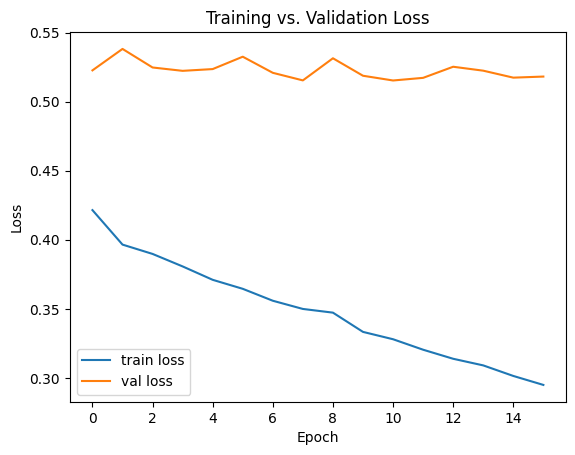

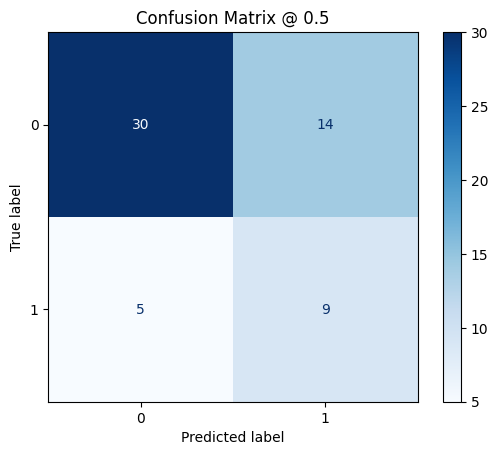

In [7]:
# Retrieve the best model from the tuner
best_model = tuner.get_best_models(num_models=1)[0]
best_hp    = tuner.get_best_hyperparameters()[0].values
print("Best hyperparameters:", best_hp)

# Early stopping callback 
es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Re-fit on training data (to capture history object)
history = best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    callbacks=[es],
    class_weight=class_weight,
    verbose=1
)

# Get predictions & probabilities on test set
y_probs = best_model.predict(X_test).ravel()
y_pred  = (y_probs >= 0.5).astype(int)

# Compute core metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_probs)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1 Score : {f1:.3f}")
print(f"ROC AUC  : {auc:.3f}")

# Plot training & validation loss curves
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

# Confusion matrix
cm   = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix @ 0.5")
plt.show()

### Cell 8: Data driven threshold selection
Due to the imbalanced nature of the data, the default 0.5 threshold might not be the best option

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Optimal threshold: 0.488 (F1 = 0.513)

Accuracy : 0.672
Precision: 0.400
Recall   : 0.714
F1 Score : 0.513
ROC AUC  : 0.643



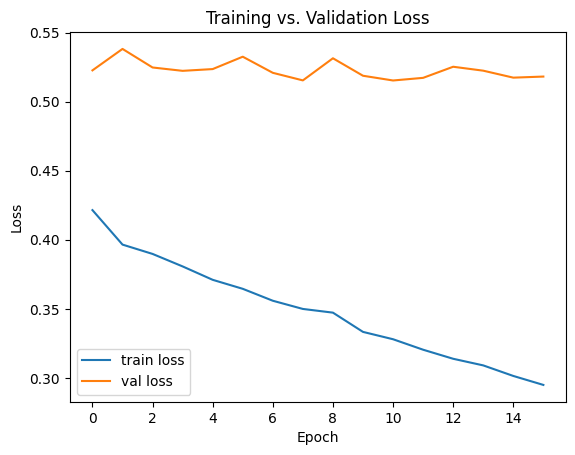

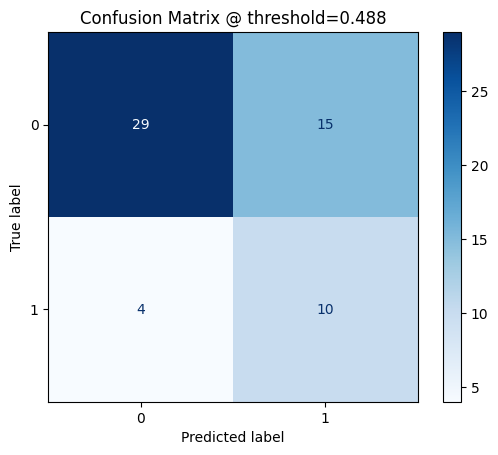

In [8]:
# Predict probabilities for the positive class
y_probs = best_model.predict(X_test).ravel()

# Compute precision & recall for all thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Compute F1 for each threshold and pick the best
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx    = np.argmax(f1_scores[:-1])  # ignore last dummy point
best_thresh = thresholds[best_idx]
best_f1     = f1_scores[best_idx]
print(f"Optimal threshold: {best_thresh:.3f} (F1 = {best_f1:.3f})\n")

# Build predictions at the optimal threshold
y_pred_opt = (y_probs >= best_thresh).astype(int)

# Compute and print core metrics
acc  = accuracy_score(y_test, y_pred_opt)
prec = precision_score(y_test, y_pred_opt)
rec  = recall_score(y_test, y_pred_opt)
f1   = f1_score(y_test, y_pred_opt)
auc  = roc_auc_score(y_test, y_probs)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1 Score : {f1:.3f}")
print(f"ROC AUC  : {auc:.3f}\n")

# Plot training vs. validation loss
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

# Confusion matrix at the optimal threshold
cm = confusion_matrix(y_test, y_pred_opt)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix @ threshold={best_thresh:.3f}")
plt.show()


# Cell 9: Compare metrics at default vs optimal threshold

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


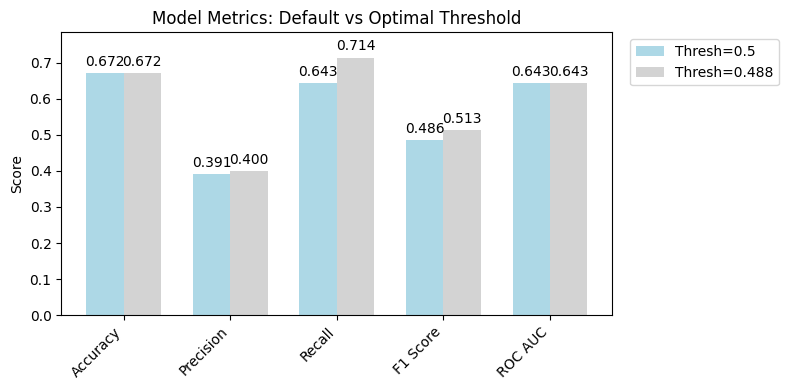

In [9]:
# Predicted probabilities
y_probs = best_model.predict(X_test).ravel()

# Metrics at default threshold = 0.5
y_pred_05 = (y_probs >= 0.5).astype(int)
metrics_05 = {
    'Accuracy': accuracy_score(y_test, y_pred_05),
    'Precision': precision_score(y_test, y_pred_05),
    'Recall': recall_score(y_test, y_pred_05),
    'F1 Score': f1_score(y_test, y_pred_05),
    'ROC AUC': roc_auc_score(y_test, y_probs)
}

# Find optimal threshold (maximize F1)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_idx    = np.argmax(f1_scores[:-1])
best_thresh = thresholds[best_idx]

# Metrics at optimal threshold
y_pred_opt = (y_probs >= best_thresh).astype(int)
metrics_opt = {
    'Accuracy': accuracy_score(y_test, y_pred_opt),
    'Precision': precision_score(y_test, y_pred_opt),
    'Recall': recall_score(y_test, y_pred_opt),
    'F1 Score': f1_score(y_test, y_pred_opt),
    'ROC AUC': roc_auc_score(y_test, y_probs)
}

# Prepare data for plotting
labels     = list(metrics_05.keys())
values_05  = [metrics_05[m] for m in labels]
values_opt = [metrics_opt[m] for m in labels]

x     = np.arange(len(labels))
width = 0.35

# Plot bars with blue shades
fig, ax = plt.subplots(figsize=(8,4))
bars1 = ax.bar(x - width/2, values_05,  width, label='Thresh=0.5', color='lightblue')
bars2 = ax.bar(x + width/2, values_opt, width, label=f'Thresh={best_thresh:.3f}', color='lightgrey')

# Annotate each bar
ax.bar_label(bars1, fmt='%.3f', padding=3)
ax.bar_label(bars2, fmt='%.3f', padding=3)

# Extend y-axis so labels fit
top_val = max(values_05 + values_opt)
ax.set_ylim(0, top_val + 0.07)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Model Metrics: Default vs Optimal Threshold')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))

plt.tight_layout()
plt.show()

### Cell 10: Export model and scaler

In [10]:
# Define directories at the project root
dirs = {
    "models":    "../models",
    "scalers":   "../scalers",
    "params":    "../params",
    "histories": "../histories",
    "env":       "../env"
}

# Create each directory if it doesn't exist
for d in dirs.values():
    os.makedirs(d, exist_ok=True)

# Save fine-tuned DNN and its scaler
print("Saving DNN model and scaler…")
best_model.save(os.path.join(dirs["models"], "dnn_model_finetuned.keras"))
joblib.dump(scaler, os.path.join(dirs["scalers"], "scaler_dnn.pkl"))

# Save best hyperparameters
print("Saving best hyperparameters…")
with open(os.path.join(dirs["params"], "dnn_best_hyperparams.json"), "w") as f:
    json.dump(best_hp, f, indent=2)

# Save training history
print("Saving training history…")
with open(os.path.join(dirs["histories"], "dnn_history.json"), "w") as f:
    json.dump(history.history, f)

# Save decision threshold
print("Saving decision threshold…")
with open(os.path.join(dirs["params"], "dnn_threshold.txt"), "w") as f:
    f.write(str(best_thresh))

# Save class-weight mapping
print("Saving class-weight dict…")
joblib.dump(class_weight, os.path.join(dirs["params"], "class_weight.pkl"))

# Capture environment requirements
print("Capturing environment requirements…")
os.system(f"pip freeze > {os.path.join(dirs['env'], 'requirements.txt')}")

print(f"\nAll artifacts saved to: {', '.join(dirs.values())}")


Saving DNN model and scaler…
Saving best hyperparameters…
Saving training history…
Saving decision threshold…
Saving class-weight dict…
Capturing environment requirements…

All artifacts saved to: ../models, ../scalers, ../params, ../histories, ../env
